# Imports

In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spellchecker import SpellChecker
from gensim.models import Word2Vec
import re
import nltk
import contractions
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Bidirectional
import numpy as np
import spacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import seaborn as sns

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

2024-10-06 17:56:56.097157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joaocosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/joaocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Reading the file and converting it to a DataFrame
def read_file_to_dataframe(filename):
    data = []
    
    with open("./data/" + filename, 'r', encoding='utf-8') as file:
        for linha in file:
            linha = linha.strip()  # Remove leading/trailing spaces and newlines
            filme = linha.split('\t')  # Split by tab
            data.append(filme)  # Append the row to the data list
    
    # Convert the list of rows to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df


# Variaveis onde está os ficheiros de treino e o modelo

In [3]:
#file onde já está o modelo treinado"
model=None
newPKL = "joao3"


#limpesa de ficheiro de treino
data="train"
#ficheiro onde vai ser feita ao autoavaliacao
avaliation = "test_no_labels"

In [4]:
print("\033[34mData to DataFrame\n\033[0m")
# Example usage
df = read_file_to_dataframe(data+".txt")
print(df)

Data to DataFrame

                              0          1        2                        3  \
0                  Ela Cheppanu     Telugu  romance                   Ramana   
1     A Nightmare on Elm Street   American   horror             Samuel Bayer   
2               American Gothic   American   horror               John Hough   
3                          Gang  Bollywood    crime              Mazhar Khan   
4            Intimate Relations    British    drama            Charles Frank   
...                         ...        ...      ...                      ...   
8036              Sa 'Yo Lamang   Filipino    drama          Laurice Guillen   
8037          The Lemon Sisters   American    drama             Joyce Chopra   
8038      Dil Ne Phir Yaad Kiya  Bollywood  romance                  Unknown   
8039  Rehnaa Hai Terre Dil Mein  Bollywood  romance            Gautham Menon   
8040             Things to Come    British   sci-fi  William Cameron Menzies   

                    

8041


Average word count: 370.33


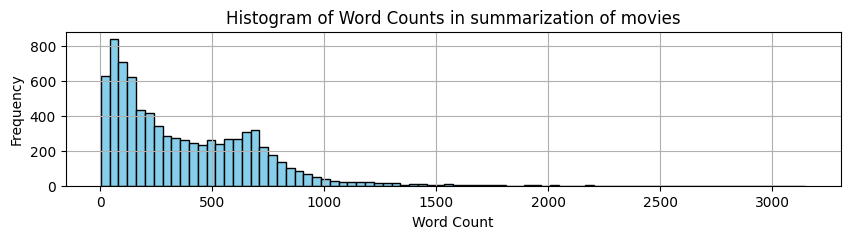

In [5]:
# histogram of word count
print(len(df))

df['word_count'] = df[4].apply(lambda x: len(x.split()))
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


the: 161014
to: 111607
and: 106034
a: 80092
of: 53504
is: 49072
his: 43843
in: 43811
he: 30869
that: 30744


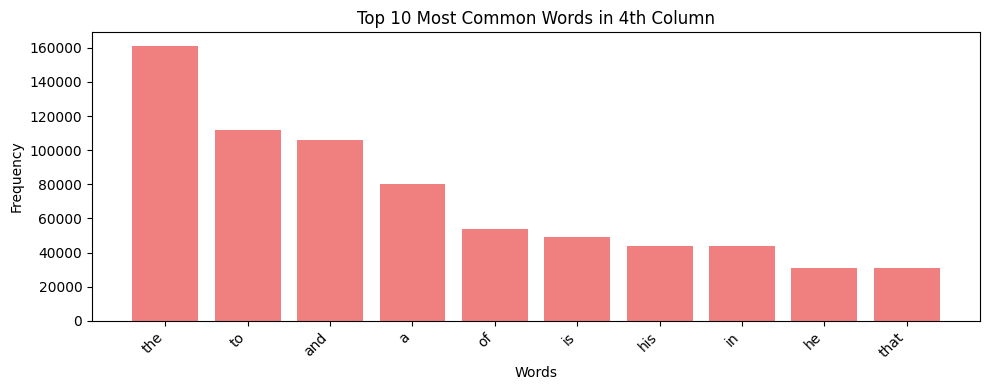

In [6]:
# Flatten all words from the 4th column into a single list
all_words = [word for row in df[4] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

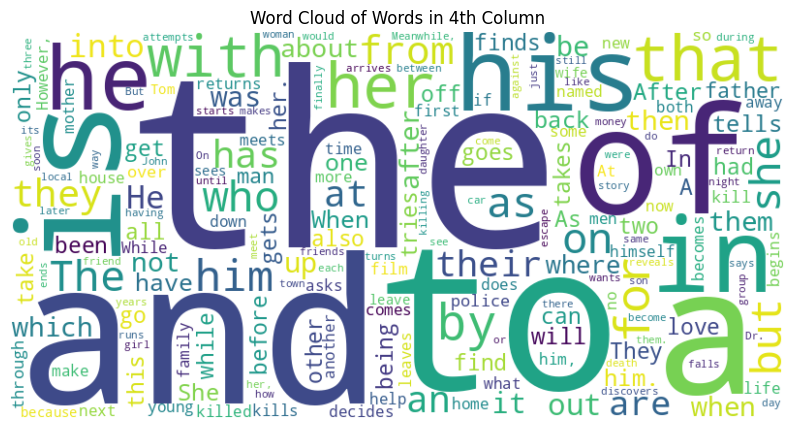

In [7]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

In [8]:
# Check for typos using the pyspellchecker
spell = SpellChecker()
misspelled_words = spell.unknown(all_words)  # Identify misspelled words

# Display the number of potential typos
print(f"Number of potential typos: {len(misspelled_words)}")

# Optionally, print the misspelled words
print("\nPotential typos detected:")
for word in misspelled_words:
    print(word)

Number of potential typos: 110045

Potential typos detected:
£1,500
(j.r.)
£550
girls.
faux-umpire
stojka),
anzac
(majors),
(angeline
harleen,
gamsey,
cave-in-rock.
toto
bogart's
kaitou's
whereabouts,
comedy-fantasy.
aldous'
devine
sign;
proposal;
pre-wedding
eleven-year-old
hiru
spouse.
penwald
kozhikode,
nails.
double-cross
liu-yuan
harris),
homeland,
hedvig,
bubblech
kung)
chloë
mcfarland
mediocre,
bascopolous.
trainee.
mcbride)
marcellus,
onlooker,
shiraishi)
wizard,
senapathi
teary-eyed.
(cannavale),
1]
narcotics,
comediennes;
king’.
ruth.
(hatch)
wadsworth
tomfoolery,
(billy
birju
bayani)
becky,
want,
yashvardhan
weiss),
feldstein.
gimnasium,
(makisig
dolemite
unworthy,
muldoon.
momar
merteuil
swan,
long-distance
bacall.
eagerness.
ballzac
kong,
(elena
widmark's
mortgaged.
petrol,
tourist,
hospitalised.
dover,
fireship
11:00pm
commiserate,
potent)
kimball),
hillcrest
heart-attack
sailor.
shoulder,
cornelius'
signal.
unhinged.
(based
hatten
frantic,
sleat
still,
narrators:
(louis


## Pre Processamento

In [9]:
# Function to standardize dates
def standardize_dates(text):
    def _month_to_number(month_name):
        try:
            return datetime.strptime(month_name, "%b").month  # Abbreviated month names (e.g., "Feb")
        except ValueError:
            try:
                return datetime.strptime(month_name, "%B").month  # Full month names (e.g., "February")
            except ValueError:
                return None  # Return None for invalid month names

    def _handle_two_digit_year(year):
        if not year:  # If year is None or empty
            return ""
        year = int(year)
        return year + 2000 if year < 100 else year

    # Date normalization using regex
    text = re.sub(
        r'(\b[A-Za-z]+) (\d{1,2})(?:st|nd|rd|th)?(?:,)? (\d{4})?',
        lambda match: (
            f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}/{match.group(3)}"
            if _month_to_number(match.group(1)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}"
            if _month_to_number(match.group(1)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    # Handle formats like "8-Feb-2013"
    text = re.sub(
        r'(\d{1,2})(?:st|nd|rd|th)?[-/.](\b[A-Za-z]+)\b[-/.]?(\d{2,4})?',
        lambda match: (
            f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}/{_handle_two_digit_year(match.group(3))}"
            if _month_to_number(match.group(2)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}"
            if _month_to_number(match.group(2)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    return text

In [10]:
# lowercasing
def lowercase_text(text):
    return text.lower()

In [11]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract and return lemmatized words
    lemmatized_words = [token.lemma_ for token in doc]
    return " ".join(lemmatized_words)

In [12]:
# stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text, stop_words=stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower()]
    return " ".join(filtered_words)

In [13]:
#contractions
def expand_contractions(text):
    if not isinstance(text, str) or not text:
        # Return an empty string or the original text if it's not a valid string
        return text

    try:
        # Use contractions.fix to expand contractions in the text
        return contractions.fix(text)
    except IndexError as e:
        print(f"IndexError encountered: {e}")
        # Optionally return the original text if there's an error
        return text


In [14]:
# Remove punctuation except for specific cases like "Dr." or "Mr."
def remove_punctuation(text):
    # Replace specific abbreviations with placeholders
    text = re.sub(r'\b(Dr|Mr|Ms|Mrs)\.', r'\1_PLACEHOLDER_', text)
    
    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Restore the abbreviations
    text = text.replace('_PLACEHOLDER_', '.')
    
    return text

In [15]:
print("\033[34mPre Processing the data\n\033[0m")
def preprocess_text(text):
    text = expand_contractions(text)       # Step 1: Expand contractions
    text = standardize_dates(text)         # Step 2: Normalize dates
    text = lowercase_text(text)            # Step 3: Convert to lowercase
    text = remove_punctuation(text)        # Step 4: Remove punctuation but keep specific cases
    text = remove_stopwords(text)          # Step 5: Remove stopwords
    text = lemmatize_text(text)            # Step 6: Lemmatize the text
    return text

# Example usage

df.iloc[:, 4] = df.iloc[:, 4].apply(preprocess_text)

print("\033[32mPre Processing Completed!\n\033[0m")

Pre Processing the data

IndexError encountered: string index out of range
IndexError encountered: string index out of range
Pre Processing Completed!



Average word count: 205.07


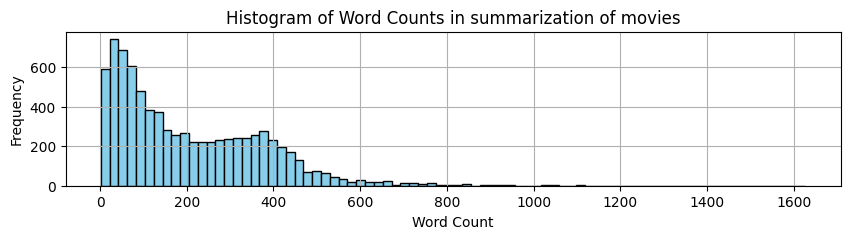

In [16]:
# histogram of word count after pre-processing
df['word_count'] = df[4].apply(lambda x: len(x.split()))
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

find: 9095
kill: 8870
take: 8490
go: 7931
get: 7738
leave: 7424
one: 6738
tell: 6638
man: 6592
back: 5702


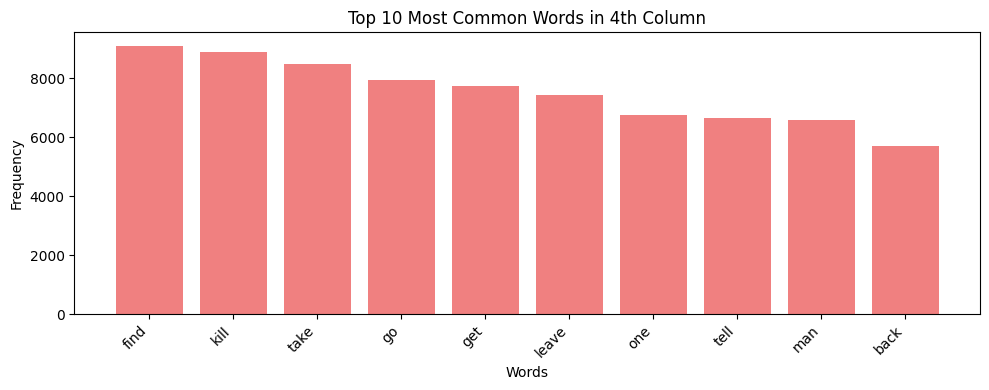

In [17]:
# Flatten all words from the 4th column into a single list after pre-processing
all_words = [word for row in df[4] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

# Data after Pre Processing

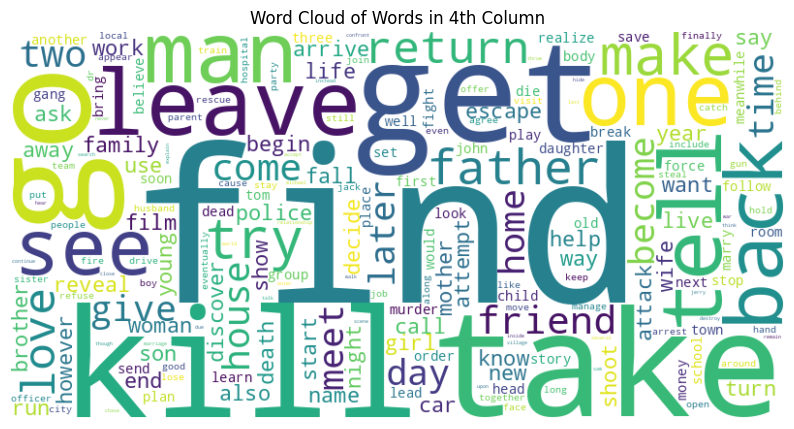

In [18]:
# Generate a word cloud after pre-processing
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

## Carregar o modelo ou Criar um novo
#### Conforme o nome dado a variavel 'newPKL'

In [19]:
plots = df.iloc[:, 4]  # Preprocess the plots
genres = df.iloc[:, 2]  # Genres

plots_train, plots_test, genres_train, genres_test = train_test_split(plots, genres, test_size=0.2, random_state=42)


In [20]:
tokenized_plots_train = [plot.split() for plot in plots_train]
embedding_dim = 300
word2vec_model = Word2Vec(sentences=tokenized_plots_train, vector_size=embedding_dim, window=5, min_count=1, sg=1, epochs=10)

In [21]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(plots_train)
sequences_train = tokenizer.texts_to_sequences(plots_train)
sequences_test = tokenizer.texts_to_sequences(plots_test)
word_index = tokenizer.word_index

In [22]:
# Pad the sequences
data_train = pad_sequences(sequences_train, maxlen=100)
data_test = pad_sequences(sequences_test, maxlen=100)

In [23]:
# Create an embedding matrix using Word2Vec trained on training data
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [24]:
# Encode the genres
label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(genres_train)
labels_test = label_encoder.transform(genres_test)

# Build and compile the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=100,
                    trainable=False))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(9, activation='softmax'))  # Assuming 9 genres

2024-10-06 18:18:31.409812: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-10-06 18:18:33.383622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-06 18:18:33.387473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-06 18:18:33.3

In [25]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Train the model on the training data
model.fit(data_train, labels_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15


2024-10-06 18:18:36.137719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-06 18:18:36.150742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-06 18:18:36.163596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 1.7273 - accuracy: 0.3598

2024-10-06 18:27:07.557069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-06 18:27:07.565962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-06 18:27:07.570599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - 522s 3s/step - loss: 1.7273 - accuracy: 0.3598 - val_loss: 1.6620 - val_accuracy: 0.3349
Epoch 2/15
161/161 [==============================] - 514s 3s/step - loss: 1.3925 - accuracy: 0.4869 - val_loss: 1.3169 - val_accuracy: 0.5089
Epoch 3/15
161/161 [==============================] - 514s 3s/step - loss: 1.2260 - accuracy: 0.5650 - val_loss: 1.2368 - val_accuracy: 0.5789
Epoch 4/15
161/161 [==============================] - 632s 4s/step - loss: 1.1550 - accuracy: 0.5858 - val_loss: 1.1947 - val_accuracy: 0.5843
Epoch 5/15
161/161 [==============================] - 625s 4s/step - loss: 1.0630 - accuracy: 0.6290 - val_loss: 1.1430 - val_accuracy: 0.6022
Epoch 6/15
161/161 [==============================] - 401s 2s/step - loss: 0.9989 - accuracy: 0.6515 - val_loss: 1.0819 - val_accuracy: 0.6247
Epoch 7/15
161/161 [==============================] - 428s 3s/step - loss: 0.9324 - accuracy: 0.6725 - val_loss: 1.2410 - val_accuracy: 0.5695
Epoch 8/15

In [27]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(data_test, labels_test)
print(f"Test Accuracy: {test_acc}")

51/51 [==============================] - 23s 446ms/step - loss: 1.2563 - accuracy: 0.6140
Test Accuracy: 0.6140459775924683


2024-10-06 19:33:29.452316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-06 19:33:29.453788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-06 19:33:29.455596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

51/51 [==============================] - 25s 471ms/step


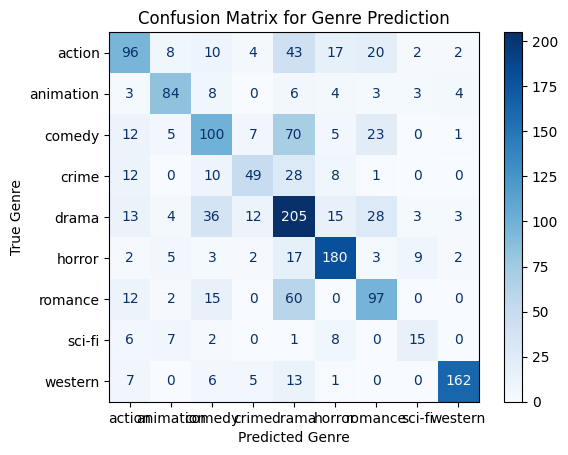

In [28]:
# Make predictions on the test set
y_pred = model.predict(data_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(labels_test, y_pred_classes)

# Optionally, display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Genre Prediction")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.show()

In [29]:
# Calculate accuracy
accuracy = accuracy_score(labels_test, y_pred_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(labels_test, y_pred_classes, average='weighted')  # Use 'macro' for unweighted average
recall = recall_score(labels_test, y_pred_classes, average='weighted')  # Use 'macro' for unweighted average
f1 = f1_score(labels_test, y_pred_classes, average='weighted')  # Use 'macro' for unweighted average

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Optional: Detailed classification report
print("\nClassification Report:\n", classification_report(labels_test, y_pred_classes, target_names=label_encoder.classes_))

Accuracy: 0.6140
Precision: 0.6250
Recall: 0.6140
F1 Score: 0.6140

Classification Report:
               precision    recall  f1-score   support

      action       0.59      0.48      0.53       202
   animation       0.73      0.73      0.73       115
      comedy       0.53      0.45      0.48       223
       crime       0.62      0.45      0.52       108
       drama       0.46      0.64      0.54       319
      horror       0.76      0.81      0.78       223
     romance       0.55      0.52      0.54       186
      sci-fi       0.47      0.38      0.42        39
     western       0.93      0.84      0.88       194

    accuracy                           0.61      1609
   macro avg       0.63      0.59      0.60      1609
weighted avg       0.62      0.61      0.61      1609



In [30]:
# Build and compile the Bidirectional LSTM modelbi
modelbi = Sequential()
modelbi.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=100,
                    trainable=False))
# Add the Bidirectional LSTM layer
modelbi.add(Bidirectional(LSTM(128, return_sequences=False)))
modelbi.add(Dropout(0.5))
modelbi.add(Dense(64, activation='relu'))
modelbi.add(Dense(9, activation='softmax'))  # Assuming 9 genres

# Compile the modelbi
modelbi.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the modelbi on the training data
modelbi.fit(data_train, labels_train, epochs=15, batch_size=32, validation_split=0.2)

2024-10-06 19:34:12.168734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-06 19:34:12.171424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-06 19:34:12.172557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/15


2024-10-06 19:34:12.638252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-06 19:34:12.642084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-06 19:34:12.644789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 1.6589 - accuracy: 0.3798

2024-10-06 19:36:31.876502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-06 19:36:31.878721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-06 19:36:31.880082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - 142s 851ms/step - loss: 1.6589 - accuracy: 0.3798 - val_loss: 1.3793 - val_accuracy: 0.4825
Epoch 2/15
161/161 [==============================] - 42s 263ms/step - loss: 1.2857 - accuracy: 0.5296 - val_loss: 1.2672 - val_accuracy: 0.5486
Epoch 3/15
161/161 [==============================] - 89s 551ms/step - loss: 1.1484 - accuracy: 0.5930 - val_loss: 1.1510 - val_accuracy: 0.5897
Epoch 4/15
161/161 [==============================] - 65s 405ms/step - loss: 1.0568 - accuracy: 0.6282 - val_loss: 1.1947 - val_accuracy: 0.5851
Epoch 5/15
161/161 [==============================] - 48s 293ms/step - loss: 0.9665 - accuracy: 0.6490 - val_loss: 1.1032 - val_accuracy: 0.6169
Epoch 6/15
161/161 [==============================] - 37s 229ms/step - loss: 0.9024 - accuracy: 0.6715 - val_loss: 1.0724 - val_accuracy: 0.6340
Epoch 7/15
161/161 [==============================] - 44s 272ms/step - loss: 0.8367 - accuracy: 0.7015 - val_loss: 1.0680 - val_accuracy: 0.

In [31]:
# Evaluate the model on the test data
test_loss, test_acc = modelbi.evaluate(data_test, labels_test)
print(f"Test Accuracy: {test_acc}")

51/51 [==============================] - 3s 57ms/step - loss: 1.4573 - accuracy: 0.6209
Test Accuracy: 0.620882511138916


2024-10-06 19:46:59.885339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-06 19:46:59.888037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-06 19:46:59.889573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

51/51 [==============================] - 4s 57ms/step


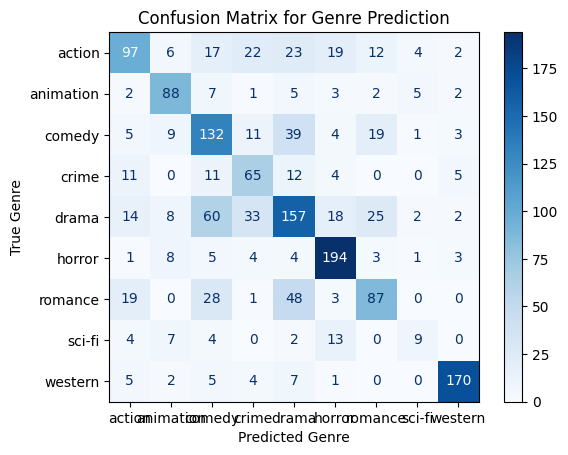

In [32]:
# Make predictions on the test set
y_pred = modelbi.predict(data_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(labels_test, y_pred_classes)

# Optionally, display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Genre Prediction")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.show()

In [33]:
# Calculate accuracy
accuracy = accuracy_score(labels_test, y_pred_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(labels_test, y_pred_classes, average='weighted')  # Use 'macro' for unweighted average
recall = recall_score(labels_test, y_pred_classes, average='weighted')  # Use 'macro' for unweighted average
f1 = f1_score(labels_test, y_pred_classes, average='weighted')  # Use 'macro' for unweighted average

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Optional: Detailed classification report
print("\nClassification Report:\n", classification_report(labels_test, y_pred_classes, target_names=label_encoder.classes_))

Accuracy: 0.6209
Precision: 0.6213
Recall: 0.6209
F1 Score: 0.6164

Classification Report:
               precision    recall  f1-score   support

      action       0.61      0.48      0.54       202
   animation       0.69      0.77      0.72       115
      comedy       0.49      0.59      0.54       223
       crime       0.46      0.60      0.52       108
       drama       0.53      0.49      0.51       319
      horror       0.75      0.87      0.80       223
     romance       0.59      0.47      0.52       186
      sci-fi       0.41      0.23      0.30        39
     western       0.91      0.88      0.89       194

    accuracy                           0.62      1609
   macro avg       0.60      0.60      0.59      1609
weighted avg       0.62      0.62      0.62      1609



Accuracy: 0.6420
Precision: 0.6577
Recall: 0.6420
F1 Score: 0.6441


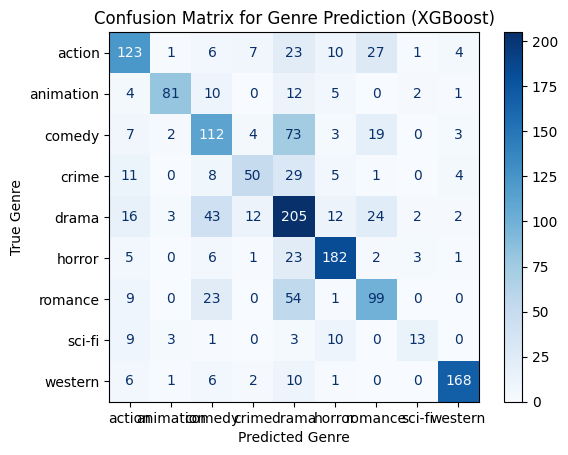


Classification Report:
               precision    recall  f1-score   support

      action       0.65      0.61      0.63       202
   animation       0.89      0.70      0.79       115
      comedy       0.52      0.50      0.51       223
       crime       0.66      0.46      0.54       108
       drama       0.47      0.64      0.55       319
      horror       0.79      0.82      0.81       223
     romance       0.58      0.53      0.55       186
      sci-fi       0.62      0.33      0.43        39
     western       0.92      0.87      0.89       194

    accuracy                           0.64      1609
   macro avg       0.68      0.61      0.63      1609
weighted avg       0.66      0.64      0.64      1609



In [37]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Step 1: Generate plot-level embeddings by averaging the word embeddings with tokenized plots
tokenized_plots_train = [plot.split() for plot in plots_train]
tokenized_plots_test = [plot.split() for plot in plots_test]

# Step 1: Generate plot-level embeddings by averaging the word embeddings
def get_average_embedding(sequences, word2vec_model, embedding_dim):
    averaged_embeddings = []
    for sequence in sequences:
        # Only use words that exist in the FastText vocabulary
        word_vectors = [word2vec_model.wv[word] for word in sequence if word in word2vec_model.wv]
        if word_vectors:
            averaged_embeddings.append(np.mean(word_vectors, axis=0))
        else:
            # If there are no words in the sequence that exist in the FastText vocab, use a zero vector
            averaged_embeddings.append(np.zeros(embedding_dim))
    return np.array(averaged_embeddings)

# Convert tokenized sequences into FastText embeddings
train_embeddings = get_average_embedding(tokenized_plots_train, word2vec_model, embedding_dim)
test_embeddings = get_average_embedding(tokenized_plots_test, word2vec_model, embedding_dim)

# Ensure no NaN values in embeddings
train_embeddings = np.nan_to_num(train_embeddings, nan=0.0, posinf=0.0, neginf=0.0)
test_embeddings = np.nan_to_num(test_embeddings, nan=0.0, posinf=0.0, neginf=0.0)

# Step 2: Train an XGBoost classifier on the averaged FastText embeddings
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(train_embeddings, labels_train)

# Step 3: Make predictions on the test set
y_pred = xgb_model.predict(test_embeddings)

# Step 4: Evaluate the model
accuracy = accuracy_score(labels_test, y_pred)
precision = precision_score(labels_test, y_pred, average='weighted')
recall = recall_score(labels_test, y_pred, average='weighted')
f1 = f1_score(labels_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 5: Generate the confusion matrix
cm = confusion_matrix(labels_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Genre Prediction (XGBoost)")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.show()

# Step 6: Optional: Detailed classification report
print("\nClassification Report:\n", classification_report(labels_test, y_pred, target_names=label_encoder.classes_))